In [1]:
import numpy as np
import tensorflow as tf
import random as rn
from my_utils import Workout_dataset#, class_weight_dict
from my_model_class import CNN_RNN_Resnet

import os

In [2]:
# seed 고정
os.environ['PYTHONHASHSEED'] = str(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

In [3]:
train_dir = './data/train'
label_dir = './data/data_y_train.csv'
test_dir = './data/test'
test_label_dir = './data/data_y_test.csv'
checkpoint_filepath = './save/cnn_gru_best.hdf5'

BATCH_SIZE = 64
valid_ratio = 4
select_fold = 0
train_patience = 30

train_loader = Workout_dataset(
    train_dir, label_dir, mode='Train',
    fold=select_fold, batch_size=BATCH_SIZE, shuffle=True, 
    augment=True, rot_prob=0.5, perm_prob=0.2)

valid_loader = Workout_dataset(
    train_dir, label_dir, mode='Valid',
    fold=select_fold, batch_size=BATCH_SIZE//valid_ratio, shuffle=True)
    #augment=True, rot_prob=0.3, perm_prob=0.1)

test_loader = Workout_dataset(
    test_dir, test_label_dir, mode='Test',
    batch_size=625, shuffle=False)


In [4]:
model = CNN_RNN_Resnet(
    leakyrelu_alpha = 0.1, #-0.2, #-0.1#, #0.05#, #0.1#, 0.2
    input_kernels = 20, # #10#, ##20##
    input_kernel_width = 3, # #3#, 5
    res_kernels = 60,# 30, #60#, 120
    res_kernel_width = 3, # #3#, 5
    res_regularize_coeff=0.1, # #0.01#, 0.1, 0.2
    res_num = 3 # ##3##, #5#, 7, 9, 11, 13
    )(lr = 0.001,seed=42)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 3)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 600, 3)]     0                                            
___________________________________________________________________________________________

In [5]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience = 4,verbose = 1,factor = 0.5) 

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',min_delta=0.0001,
    patience=train_patience,verbose=1)

history = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=2000,
    callbacks=[save_best,early_stop,lr_scheduler])
    #class_weight=class_weight_dict(bias=0))


Epoch 1/2000
34/34 [==============================] - 75s 728ms/step - loss: 100.4983 - accuracy: 0.4439 - val_loss: 59.3718 - val_accuracy: 0.4453

Epoch 00001: val_loss improved from inf to 59.37181, saving model to ./save/cnn_gru_best.hdf5
Epoch 2/2000
34/34 [==============================] - 16s 460ms/step - loss: 38.8586 - accuracy: 0.5763 - val_loss: 25.0169 - val_accuracy: 0.4492

Epoch 00002: val_loss improved from 59.37181 to 25.01691, saving model to ./save/cnn_gru_best.hdf5
Epoch 3/2000
34/34 [==============================] - 16s 459ms/step - loss: 15.4686 - accuracy: 0.6452 - val_loss: 11.2405 - val_accuracy: 0.4570

Epoch 00003: val_loss improved from 25.01691 to 11.24050, saving model to ./save/cnn_gru_best.hdf5
Epoch 4/2000
34/34 [==============================] - 16s 465ms/step - loss: 6.6801 - accuracy: 0.6328 - val_loss: 6.1389 - val_accuracy: 0.4492

Epoch 00004: val_loss improved from 11.24050 to 6.13891, saving model to ./save/cnn_gru_best.hdf5
Epoch 5/2000
34/34 

In [6]:

model.load_weights(checkpoint_filepath)
model.evaluate(test_loader,verbose=1)


1/1 [==============================] - 2s 2s/step - loss: 0.5499 - accuracy: 0.8688


[0.5498624444007874, 0.8687999844551086]

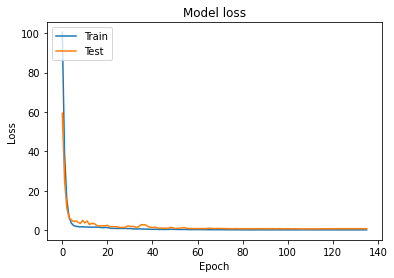

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()